# Analysis Part III - Specificity Annotation

In [1]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore')
import os
import scanpy as sc
import scirpy as ir
import anndata as ann
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mudata import MuData
import mudata

import tarfile
import warnings
from glob import glob

import anndata
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import scirpy as ir

%autoreload 2
import sys
sys.path.append('..')
import utility.annotation as utils_annotation
import utility.representation as utils_representation
import utility.visualisation as utils_vis

from sklearn.mixture import GaussianMixture

In [ ]:
import dextramixer

In [6]:
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sc.set_figure_params(vector_friendly=True, color_map='viridis', transparent=True)
sb.set_style('whitegrid')

colormap = 'flare'

## Read data

In [7]:
mdata = mu.read("/media/agschober/HDD12/3_scRNA-Seq_Sina/2_Merge_Data/data_ALL_normalised.h5mu")

In [8]:
for ep in mdata["gex"].uns['epitopes']:
    mdata["gex"].obs[f'log_{ep}'] = np.log(mdata["gex"].obs[ep]+1)

In [9]:
mdata["gex"].obs['n_count_dextramer'] = np.sum(mdata["gex"].obsm['epitopes'], axis=1)
mdata["gex"].obs['n_max_dextramer'] = np.max(mdata["gex"].obsm['epitopes'], axis=1)
mdata["gex"].obs['max_dextramer'] = np.nanargmax(mdata["gex"].obsm['epitopes'], axis=1)
mdata["gex"].obs['max_dextramer'] = mdata["gex"].obs['max_dextramer'].apply(lambda x: mdata["gex"].uns['epitopes'][x])
mdata["gex"].obs['max_dextramer'][mdata["gex"].obs['n_max_dextramer']==0] = 'NONE'
mdata["gex"].obs['%_max_dextramer'] = mdata["gex"].obs['n_max_dextramer'] / mdata["gex"].obs['n_count_dextramer']

mdata["gex"].obs['clone_id'] = mdata["airr"].obs['clone_id']

In [10]:
mdata['gex'].obs['dataset'] = 'exp'
mdata['gex'].obs['dataset'][mdata['gex'].obs['sample'].isin(['sample1', 'sample2', 'sample3', 'sample4'])] = 'exp1'
mdata['gex'].obs['dataset'][mdata['gex'].obs['sample'].isin(['sample5', 'sample6', 'sample7', 'sample8'])] = 'exp2'
mdata['gex'].obs['dataset'][mdata['gex'].obs['sample'].isin(['sample9'])] = 'exp3'

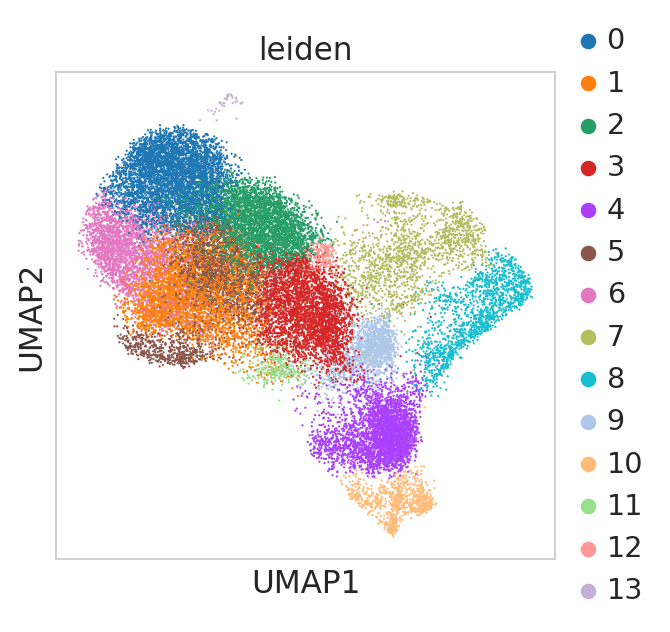

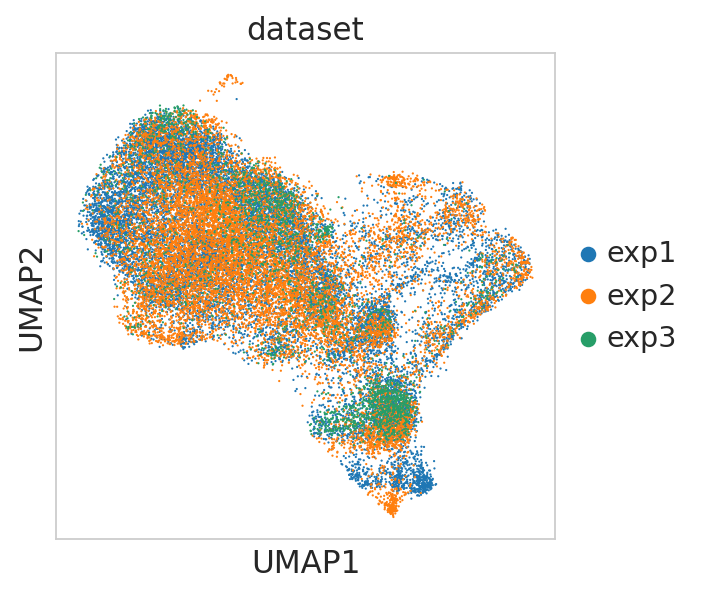

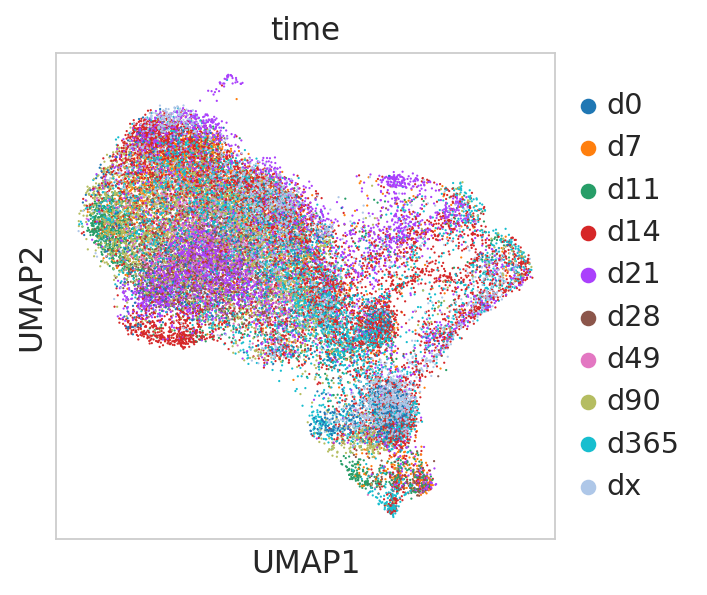

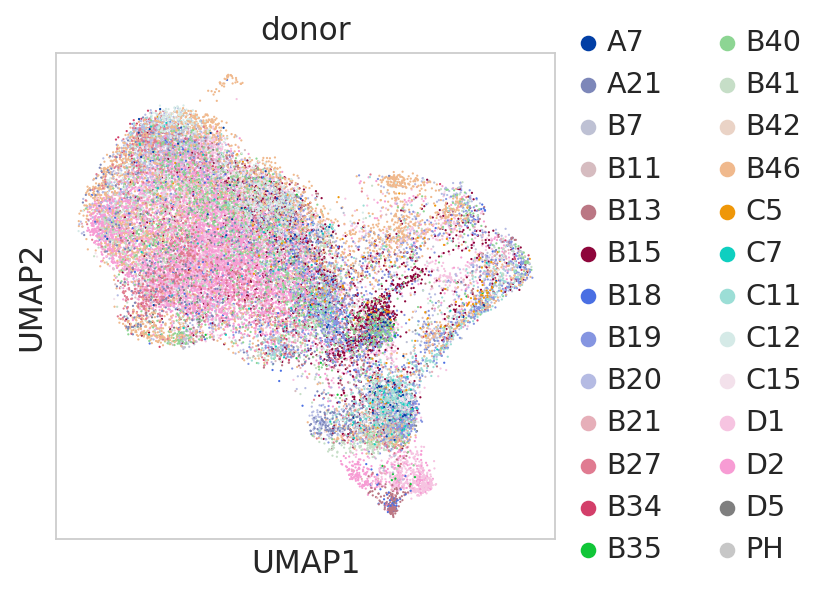

In [11]:
sc.pl.umap(mdata["gex"], color=['leiden'])
sc.pl.umap(mdata["gex"], color=['dataset'])
sc.pl.umap(mdata["gex"], color=['time'])
sc.pl.umap(mdata["gex"], color=['donor'])

## Specificity annotation

### Clone Purity over all cells before any cutoff

In [ ]:
#plot clone purity (before UMI filtering)
df = pd.concat([mdata["gex"].obs['n_count_dextramer'], mdata["gex"].obs['n_max_dextramer'], 
                mdata["gex"].obs['%_max_dextramer'], mdata["gex"].obs['max_dextramer'],
                mdata["gex"].obs['clone_id']], axis=1)

for i in mdata["gex"].uns['epitopes']:
    df[i] = 0
    df[i][df['max_dextramer']==i] = 1

df = df.drop(['max_dextramer'], axis=1)
dff = df.groupby('clone_id').mean().reset_index()

#plot clone id versus epitope purity
for i in mdata["gex"].uns['epitopes']:
    fig, ax = plt.subplots(figsize=(5, 2))
    y=dff[i].sort_values().to_list()
    plt.plot(y)
    plt.title(i)
    plt.show()
    
#due to "mean" the number for the epitopes now equals the mean amount of positive cells per clone

## 1st Experiment

#### Predictions with variable clone purity

In [ ]:
#Specificity prediction with variable clonepurity
ep = ['NS4B214', 'NS2B117', 'NS3293', 'NS3286', 'NS324', 'NS5672', 
      'NS2A97', 'NS4B165', 'COV', 'HHV', 'FLU', 'EBV1', 'EBV2']

clonepurity = np.arange(0.01, 1.01, 0.025)

x= pd.DataFrame(columns=['NS4B214','NS2B117','NS3293','NS3286','NS324','NS5672','NS2A97','NS4B165','COV','HHV',
                         'FLU','EBV1','EBV2', 'clone_purity'], index=range(len(clonepurity)))

#choose only data from first experiment
data = mdata[mdata['gex'].obs['dataset']=='exp1']

#generate the table for all cells and epitopes
z = pd.concat([data["gex"].obs[ep],
                   data["gex"].obs['n_count_dextramer'],
                   data["gex"].obs['n_max_dextramer'],
                   data["gex"].obs['max_dextramer'],
                   data["gex"].obs['%_max_dextramer'],
                   data["gex"].obs['clone_id'],
                   data["gex"].obs['clone_size']], axis=1)

#remove cells that do not belong to any clone (clone_id = Nan)
z = z[z['clone_id']>=0]

#start the loop for going through the epitopes
for i in range(len(ep)):
    z['max'] = 0
    z['max_dextramer'] = data["gex"].obs['max_dextramer'] 
    z[ep[i]+'_pur'] = z[ep[i]]/z['n_count_dextramer'] 
    z[ep[i]+'_keep'] = 'no' 
    z[ep[i]+'_prediction'] = 'no'

    #train model on clones with more than 5 cells
    X = np.array((z[z['clone_size']>=5][[ep[i],ep[i]+'_pur']]).dropna())
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    
    #to make sure that 1 always corresponds to the higher values
    if (gm.means_[0][0] < gm.means_[1][0]):
        print('ok')
    else:
        print('ohoh')
        
  
    #use model to filter (predict by cell purity and UMI counts, exclude cells with less than 3 counts)
    for c in range(len(z)):
        if z[ep[i]][c] is not None and np.any(z[ep[i]][c]):
            if (gm.means_[0][0] < gm.means_[1][0]):
                if ((z[ep[i]][c] >= 0) & (z[ep[i]+'_pur'][c] >= 0) & (z['n_count_dextramer'][c] > 3)):
                    z[ep[i]+'_prediction'][c] = gm.predict([[z[ep[i]][c], z[ep[i]+'_pur'][c]]])
                else:
                    z[ep[i]+'_prediction'][c] = 2 
            else:
                if ((z[ep[i]][c] >= 0) & (z[ep[i]+'_pur'][c] >= 0) & (z['n_count_dextramer'][c] > 3)):
                    if gm.predict([[z[ep[i]][c], z[ep[i]+'_pur'][c]]]) == 0:
                        z[ep[i]+'_prediction'][c] = 1
                    else:
                        z[ep[i]+'_prediction'][c] = 0
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
        
    #filter by variable clone purities and note how many clones would still be left
    z['max'][z['max_dextramer'] != ep[i]] = 0 
    z['max'][z[ep[i]+'_prediction'] == 0] = 0 
    z['max'][(z[ep[i]].isna() == True) & (z[ep[i]+'_prediction'] == 2)] = np.nan 
    z['max'][(z[ep[i]].isna() == False) & (z[ep[i]+'_prediction'] == 2)] = 0
    z['max'][(z['max_dextramer'] == ep[i]) & (z[ep[i]+'_prediction'] == 1)] = 1 

    for p in range(len(clonepurity)):
        y = pd.DataFrame(z.groupby('clone_id')['max'].mean()) 
        goodclones = (y[y['max']>clonepurity[p]]).index
        x['clone_purity'][p] = clonepurity[p]
        x[ep[i]][p]= len(goodclones)

In [ ]:
for i in range(len(ep)):
    sb.lineplot(data=x, x='clone_purity', y=ep[i])
    plt.show()

In [ ]:
fig, ax = plt.subplots()
sb.set_palette('husl',13)
for i in range(len(ep)):
    sb.lineplot(data=x, x='clone_purity', y=ep[i], ax=ax, label=ep[i])
ax.set_xlim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5, handlelength=1.5)
ax.set_xlabel('Clone Purity')
ax.set_ylabel('Number of Clones')
ax.axvline(x=0.6, color='black', linestyle='--')
plt.show()

#### Prediction with Clone Purity set to 0.6

In [ ]:
#Specificity prediction with set clonepurity
ep = ['NS4B214', 'NS2B117', 'NS3293', 'NS3286', 'NS324', 'NS5672', 
      'NS2A97', 'NS4B165', 'COV', 'HHV', 'FLU', 'EBV1', 'EBV2']

clonepurity = 0.6

#choose only data from first experiment
data = mdata[mdata['gex'].obs['dataset']=='exp1']

#generate the table for all cells and epitopes
z = pd.concat([data["gex"].obs[ep],
                   data["gex"].obs['n_count_dextramer'],
                   data["gex"].obs['n_max_dextramer'],
                   data["gex"].obs['max_dextramer'],
                   data["gex"].obs['%_max_dextramer'],
                   data["gex"].obs['clone_id'],
                   data["gex"].obs['clone_size']], axis=1)

#remove cells that do not belong to any clone (clone_id = Nan) --> account for this case later to save also nan cells
#z = z[z['clone_id']>=0]

#start the loop for going through the epitopes
for i in range(len(ep)):
    z['max'] = 0
    z['max_dextramer'] = data["gex"].obs['max_dextramer'] #need to add this column every round as it gets changed
    
    z[ep[i]+'_pur'] = z[ep[i]]/z['n_count_dextramer'] #cell purity for every epitope
    z[ep[i]+'_keep'] = 'no' 
    z[ep[i]+'_prediction'] = 'no'

    #train model on clones with more than 5 cells
    X = np.array((z[z['clone_size']>=5][[ep[i],ep[i]+'_pur']]).dropna())
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    
    #to make sure that 1 always corresponds to the higher values
    if (gm.means_[0][0] < gm.means_[1][0]):
        print('ok')
    else:
        print('ohoh')
    
    #use model to filter (predict by cell purity and UMI counts, exclude cells with less than 3 counts)
    for c in range(len(z)):
        if z[ep[i]][c] is not None and np.any(z[ep[i]][c]):
            if (gm.means_[0][0] < gm.means_[1][0]):
                if ((z[ep[i]][c] >= 0) & (z[ep[i]+'_pur'][c] >= 0) & (z['n_count_dextramer'][c] > 3)):
                    z[ep[i]+'_prediction'][c] = gm.predict([[z[ep[i]][c], z[ep[i]+'_pur'][c]]])
                else:
                    z[ep[i]+'_prediction'][c] = 2 
            else:
                if ((z[ep[i]][c] >= 0) & (z[ep[i]+'_pur'][c] >= 0) & (z['n_count_dextramer'][c] > 3)):
                    if gm.predict([[z[ep[i]][c], z[ep[i]+'_pur'][c]]]) == 0:
                        z[ep[i]+'_prediction'][c] = 1
                    else:
                        z[ep[i]+'_prediction'][c] = 0
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
        
    #filter by clone purity - to calculate the clone purity set cells to be counted specific (1) or not specific (0)
    #or not counted at all (nan)
    
    z['max'][z['max_dextramer'] != ep[i]] = 0 #cells with another maximum dextramer don't contribute to clone purity 
    z['max'][z[ep[i]+'_prediction'] == 0] = 0 #cells that are predicted not to be specific don't contribute to clone purity
    z['max'][(z[ep[i]].isna() == True) & (z[ep[i]+'_prediction'] == 2)] = np.nan #cells with no dextramer count and no prediction are not counted
    z['max'][(z[ep[i]].isna() == False) & (z[ep[i]+'_prediction'] == 2)] = 0 #cells with dextramer counts but no prediction do not contribute to clone purity
    z['max'][(z['max_dextramer'] == ep[i]) & (z[ep[i]+'_prediction'] == 1)] = 1 #cells with positive prediction do contribute to clone purity
  
    y = pd.DataFrame(z[z['clone_id']>=0].groupby('clone_id')['max'].mean()) #the mean values equal clone purity
    goodclones = (y[y['max']>=clonepurity]).index #list of clones to include
    badclones = (y[y['max']<clonepurity]).index #list of clones to exclude

    #generate input for "keep" column
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==1] = 'yes_prediction' #cells to count as specific due to their prediction
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==0] = 'no_prediction' #cells that are unspecific according to the prediction
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==2] = 'not_predicted' #cells without prediction
    #take clone purity into account
    z[ep[i]+'_keep'][(z['clone_id'].isin(goodclones)) & (z[ep[i]+'_keep'] != 'yes_prediction')] = 'yes_clone' #include cells if the rest of their clone is ok
    z[ep[i]+'_keep'][(z['clone_id'].isin(badclones)) & (z[ep[i]+'_keep'] == 'yes_prediction')] = 'no_clone' 

#### Stripplots

In [ ]:
pal = {'yes_prediction' : 'green', 
       'no_prediction' : 'black',
       'not_predicted' : 'darkgrey',
       'yes_clone': 'lightgreen',
       'no_clone' : 'grey',
       'no': 'yellow'}

In [ ]:
#which clones are in exp1?
clones = (mdata['gex'].obs['clone_id'][mdata['gex'].obs['dataset']=='exp1']).unique()
len(clones)

In [ ]:
#plot the clones
sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

lower = range(0, 5910, 30)

upper = range(30, 5940, 30)

for i,j in zip(lower,upper):
    sb.stripplot(data=z[(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             x=z['clone_id'][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             y=z['NS4B214'][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             hue=z['NS4B214_keep'][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], palette=pal, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Exp1_NS4B214_stripplots_clone_{i}-{j}.png', dpi=600)
    plt.show()

In [ ]:
#other epitopes
epitopes = ['NS2B117', 'NS3293', 'NS3286', 'NS324', 'NS5672', 'NS2A97', 'NS4B165', 'COV', 'HHV', 'FLU', 'EBV1', 'EBV2']

sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

lower = range(0, 5910, 30)

upper = range(30, 5940, 30)

for e in epitopes:
    for i,j in zip(lower,upper):
        sb.stripplot(data=z[(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             x=z['clone_id'][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             y=z[e][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], 
             hue=z[e+'_keep'][(z['clone_id']>=clones[i])&(z['clone_id']<clones[j])], palette=pal, legend=False, jitter=True)
        plt.figsize=(150,10)
        plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Exp1_{e}_stripplots_clone_{i}-{j}.png', dpi=600)
        plt.show()

### Annotate the specific cells in mdata

In [ ]:
#select cells to annotate in data - rather cells than clones, otherwise the NAN clone cells are lost again
#mark whether NS4B214 was annotated due to prediction or clone

mdata["gex"].obs['specific'] = 'no_binding'

mdata["gex"].obs['specific'][(mdata["gex"].obs.index.isin(z.index[z['NS4B214_keep'].isin(['yes_prediction'])]))&
                             (mdata["gex"].obs['dataset']=='exp1')] = 'NS4B214'

mdata["gex"].obs['specific'][(mdata["gex"].obs.index.isin(z.index[z['NS4B214_keep'].isin(['yes_clone'])]))&
                             (mdata["gex"].obs['dataset']=='exp1')] = 'NS4B214_c'

#loop over other specificities
epitopes = ['NS2B117', 'NS3293', 'NS3286', 'NS324', 'NS5672', 'NS2A97', 'NS4B165', 'COV', 'HHV', 'FLU', 'EBV1', 'EBV2']

for e in epitopes:
    mdata["gex"].obs['specific'][(mdata["gex"].obs.index.isin(z.index[z[e+'_keep'].isin(['yes_prediction', 'yes_clone'])]))&
                             (mdata["gex"].obs['dataset']=='exp1')] = e

## 2nd and 3rd Experiment

In [ ]:
#set highest values to 100 so values are not so skewed in one direction but only temporarily
mdata['gex'].obs['NS4B214_adj'] = mdata['gex'].obs['NS4B214']
mdata['gex'].obs['NS4B214_adj'][(mdata['gex'].obs['dataset'].isin(['exp2', 'exp3']))&(mdata['gex'].obs['NS4B214']>100)] = 100

#### Find the shared clones and divide by their specificity in exp1

In [ ]:
exp1_goodclones = (mdata['gex'].obs['clone_id'][(mdata['gex'].obs['dataset']=='exp1')&
                                                (mdata['gex'].obs['specific'].isin(['NS4B214', 'NS4B214_c']))]).unique()
exp1_badclones = (mdata['gex'].obs['clone_id'][(mdata['gex'].obs['dataset']=='exp1')&
                                               (~mdata['gex'].obs['specific'].isin(['NS4B214', 'NS4B214_c']))]).unique()

In [ ]:
exp1_goodclones = exp1_goodclones[~np.isnan(exp1_goodclones)]
exp1_badclones = exp1_badclones[~np.isnan(exp1_badclones)]

In [ ]:
newgoodcells = mdata['gex'][(mdata['gex'].obs['dataset'].isin(['exp2', 'exp3']))&
                           (mdata['gex'].obs['clone_id'].isin(exp1_goodclones))]

In [ ]:
newbadcells = mdata['gex'][(mdata['gex'].obs['dataset'].isin(['exp2', 'exp3']))&
                           (mdata['gex'].obs['clone_id'].isin(exp1_badclones))]

In [ ]:
#merge newgoodcells and newbadcells to get the dataframe to train the model
cells = newgoodcells.concatenate(newbadcells, join='inner')

In [ ]:
clones = (cells.obs['clone_id']).unique()
clones = clones[~np.isnan(clones)]
clones.sort()

#### Predictions with variable clone purity

In [ ]:
#Specificity prediction with variable clonepurity - only take umi counts into account --> remove outlier before!!!
#try to use values that are maximum 100 - train with known clones
ep = ['NS4B214_adj']

val = mdata['gex'][mdata['gex'].obs['dataset'].isin(['exp2', 'exp3'])]

clonepurity = np.arange(0.01, 1.025, 0.025)

x= pd.DataFrame(columns=['NS4B214_adj', 'clone_purity'], index=range(len(clonepurity)))

#generate the table for all cells and epitopes
z = pd.concat([val.obs[ep],
                   val.obs['n_count_dextramer'],
                   val.obs['n_max_dextramer'],
                   val.obs['max_dextramer'],
                   val.obs['%_max_dextramer'],
                   val.obs['clone_id'],
                   val.obs['clone_size']], axis=1)

#discard nan clones
z = z[z['clone_id']>=0]

#start the loop for going through the epitopes
for i in range(len(ep)):
    z[ep[i]+'_keep'] = 'no' 
    z[ep[i]+'_prediction'] = 'no'
    z['max'] = 0

    #train model on clones with more than 5 cells
    X = np.array((cells.obs[['NS4B214_adj']]).dropna()) #train on shared clones
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    
    #to make sure that 1 always corresponds to the higher values
    if (gm.means_[0][0] < gm.means_[1][0]):
        print('ok')
    else:
        print('ohoh')
    
    #use model to filter (predict by cell purity and UMI counts, exclude cells with less than 3 counts)
    for c in range(len(z)):
        if z[ep[i]][c] is not None and np.any(z[ep[i]][c]):
            if (gm.means_[0][0] < gm.means_[1][0]):
                if ((z[ep[i]][c] >= 0) & (z['n_count_dextramer'][c] > 5)):
                    z[ep[i]+'_prediction'][c] = gm.predict([[z[ep[i]][c]]])
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
            else:
                if ((z[ep[i]][c] >= 0) & (z['n_count_dextramer'][c] > 5)):
                    if gm.predict([[z[ep[i]][c]]]) == 0:
                        z[ep[i]+'_prediction'][c] = 1
                    else:
                        z[ep[i]+'_prediction'][c] = 0
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
        
    #filter by variable clone purities and note how many clones would still be left
    z['max'][z['max_dextramer'] != 'NS4B214'] = 0 
    z['max'][z[ep[i]+'_prediction'] == 0] = 0 
    z['max'][(z[ep[i]].isna() == True) & (z[ep[i]+'_prediction'] == 2)] = np.nan 
    z['max'][(z[ep[i]].isna() == False) & (z[ep[i]+'_prediction'] == 2)] = 0
    z['max'][(z['max_dextramer'] == 'NS4B214') & (z[ep[i]+'_prediction'] == 1)] = 1 

    for p in range(len(clonepurity)):
        y = pd.DataFrame(z.groupby('clone_id')['max'].mean()) 
        goodclones = (y[y['max']>clonepurity[p]]).index
        x['clone_purity'][p] = clonepurity[p]
        x[ep[i]][p]= len(goodclones)

In [ ]:
fig, ax = plt.subplots()
sb.set_palette('husl',13)
sb.lineplot(data=x, x='clone_purity', y=ep[i], ax=ax, label='NS4B214_adj')
ax.set_xlim(0, 1)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), markerscale=0.5, handlelength=1.5)
ax.set_xlabel('Clone Purity')
ax.set_ylabel('Number of Clones')
ax.axvline(x=0.6, color='black', linestyle='--')
plt.show()

#### Prediction with Clone Purity set to 0.6

In [ ]:
#full prediction with this training group and 0.6 clone purity as in the previous experiment, leaving in the nan cells!
ep = ['NS4B214_adj']

clonepurity = 0.6

val = mdata['gex'][mdata['gex'].obs['dataset'].isin(['exp2', 'exp3'])]

#generate the table for all cells and epitopes
z = pd.concat([val.obs[ep],
                   val.obs['n_count_dextramer'],
                   val.obs['n_max_dextramer'],
                   val.obs['max_dextramer'],
                   val.obs['%_max_dextramer'],
                   val.obs['clone_id'],
                   val.obs['clone_size'],
                   val.obs['donor']], axis=1)

#remove cells that do not belong to any clone (clone_id = Nan)
#z = z[z['clone_id_merged']>=0]

#start the loop for going through the epitopes
for i in range(len(ep)):
    z[ep[i]+'_keep'] = 'no' 
    z[ep[i]+'_prediction'] = 'no'
    z['max'] = 0

    #train model on clones
    X = np.array((cells.obs[['NS4B214_adj']]).dropna()) #train on the known clones!
    gm = GaussianMixture(n_components=2, random_state=0).fit(X)
    
    #to make sure that 1 always corresponds to the higher values
    if (gm.means_[0][0] < gm.means_[1][0]):
        print('ok')
    else:
        print('ohoh')
    
    #use model to filter (predict by cell purity and UMI counts, exclude cells with less than 5 counts)
    for c in range(len(z)):
        if z[ep[i]][c] is not None and np.any(z[ep[i]][c]):
            if (gm.means_[0][0] < gm.means_[1][0]):
                if ((z[ep[i]][c] >= 0) & (z['n_count_dextramer'][c] > 5)):
                    z[ep[i]+'_prediction'][c] = gm.predict([[z[ep[i]][c]]])
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
            else:
                if ((z[ep[i]][c] >= 0) & (z['n_count_dextramer'][c] > 5)):
                    if gm.predict([[z[ep[i]][c]]]) == 0:
                        z[ep[i]+'_prediction'][c] = 1
                    else:
                        z[ep[i]+'_prediction'][c] = 0
                else:
                    z[ep[i]+'_prediction'][c] = 2 #cells with no prediction
        
    #filter by clone purity - to calculate the clone purity set cells to be counted specific (1) or not specific (0)
    #or not counted at all (nan)
    z['max'][z['max_dextramer'] != 'NS4B214'] = 0 #cells with another maximum dextramer don't contribute to clone purity 
    z['max'][z[ep[i]+'_prediction'] == 0] = 0 #cells that are predicted not to be specific don't contribute to clone purity
    z['max'][(z[ep[i]].isna() == True) & (z[ep[i]+'_prediction'] == 2)] = np.nan #cells with no dextramer count and no prediction are not counted
    z['max'][(z[ep[i]].isna() == False) & (z[ep[i]+'_prediction'] == 2)] = 0 #cells with dextramer counts but no prediction do not contribute to clone purity
    z['max'][(z['max_dextramer'] == 'NS4B214') & (z[ep[i]+'_prediction'] == 1)] = 1 #cells with positive prediction do contribute to clone purity
  
    y = pd.DataFrame(z[z['clone_id']>=0].groupby('clone_id')['max'].mean()) #the mean values equal clone purity
    goodclones = (y[y['max']>=clonepurity]).index #list of clones to include
    badclones = (y[y['max']<clonepurity]).index #list of clones to exclude

    #generate input for "keep" column
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==1] = 'yes_prediction' #cells to count as specific due to their prediction
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==0] = 'no_prediction' #cells that are unspecific according to the prediction
    z[ep[i]+'_keep'][z[ep[i]+'_prediction']==2] = 'not_predicted' #cells without prediction
    #take clone purity into account
    z[ep[i]+'_keep'][(z['clone_id'].isin(goodclones)) & (z[ep[i]+'_keep'] != 'yes_prediction')] = 'yes_clone' #include cells if the rest of their clone is ok
    z[ep[i]+'_keep'][(z['clone_id'].isin(badclones)) & (z[ep[i]+'_keep'] == 'yes_prediction')] = 'no_clone' 

### Annotate the specific cells in mdata

In [ ]:
#select cells to annotate in data - rather cells than clones, otherwise the NAN clone cells are lost again
#mark whether NS4B214 was annotated due to prediction or clone

mdata["gex"].obs['specific'][(mdata["gex"].obs.index.isin(z.index[z['NS4B214_adj_keep'].isin(['yes_prediction'])]))&
                             (mdata["gex"].obs['dataset'].isin(['exp2', 'exp3']))] = 'NS4B214'

mdata["gex"].obs['specific'][(mdata["gex"].obs.index.isin(z.index[z['NS4B214_adj_keep'].isin(['yes_clone'])]))&
                             (mdata["gex"].obs['dataset'].isin(['exp2', 'exp3']))] = 'NS4B214_c'

#### Stripplots

In [ ]:
pal = {'yes_prediction' : 'green', 
       'no_prediction' : 'black',
       'not_predicted' : 'darkgrey',
       'yes_clone': 'lightgreen',
       'no_clone' : 'grey',
       'no': 'yellow'}

In [ ]:
pal2 = {'NS4B214' : 'green',
        'NS4B214_c' : 'lightgreen',
        'NS2B117' : 'black',
        'NS3286' : 'black',
        'NS3293' : 'black',
        'NS2A97' : 'black',
        'COV' : 'black',
        'EBV1': 'black',
        'EBV2' : 'black',
        'FLU' : 'black',
        'HHV' : 'black',
        'no_binding': 'purple'}

In [ ]:
#which clones are in exp2/3?
clo = (mdata['gex'].obs['clone_id'][mdata['gex'].obs['dataset'].isin(['exp2', 'exp3'])]).unique()
len(clo)

In [ ]:
#plot the exp1 shared clones
sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

lower = range(0, 270, 30)

upper = range(30, 300, 30)

new = z[z['clone_id'].isin(clones)]
old = mdata['gex'].obs[mdata['gex'].obs['clone_id'].isin(clones)]

for i,j in zip(lower,upper):
    sb.stripplot(data=new[(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             x=new['clone_id'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             y=new['NS4B214'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             hue=new['NS4B214_keep'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], palette=pal, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Shared_NS4B214_clones_{i}-{j}.png', dpi=600)
    plt.show()
    
    sb.stripplot(data=old[(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             x=old['clone_id'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             y=old['NS4B214'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             hue=old['specific'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
                 palette=pal2, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Shared_NS4B214_clones_{i}-{j}_all.png', dpi=600)
    plt.show()

In [ ]:
#recalculate clone purity for the shared clones --> dont do that now as they need to be combined with the other model!
for c in clones:
    a = len(mdata['gex'].obs['specific'][mdata['gex'].obs['clone_id'] == c])
    b = len(mdata['gex'].obs['specific'][(mdata['gex'].obs['clone_id'] == c)&
                                         (mdata['gex'].obs['specific'] == 'NS4B214')])
    pur = b/a
    if pur >= 0.6:
        mdata['gex'].obs['specific'][mdata['gex'].obs['clone_id'] == c] = 'NS4B214'
    else:
        mdata['gex'].obs['specific'][mdata['gex'].obs['clone_id'] == c] = 'no_binding'

In [ ]:
#transform the rest of the NS4B214_c into NS4B214 as clone purity information is not necessary anymore
mdata['gex'].obs['specific'][mdata['gex'].obs['specific'] == 'NS4B214_c'] = 'NS4B214'

In [ ]:
#replot the shared clones and save pictures
sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

lower = range(0, 270, 30)

upper = range(30, 300, 30)

new = z[z['clone_id'].isin(clones)]
old = mdata['gex'].obs[mdata['gex'].obs['clone_id'].isin(clones)]

for i,j in zip(lower,upper):
    sb.stripplot(data=new[(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             x=new['clone_id'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             y=new['NS4B214'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], 
             hue=new['NS4B214_keep'][(new['clone_id']>=clones[i])&(new['clone_id']<clones[j])], palette=pal, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Shared_NS4B214_clones_{i}-{j}_purity_adjusted.png', dpi=600)
    plt.show()
    
    sb.stripplot(data=old[(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             x=old['clone_id'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             y=old['NS4B214'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
             hue=old['specific'][(old['clone_id']>=clones[i])&(old['clone_id']<clones[j])], 
                 palette=pal2, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Shared_NS4B214_clones_{i}-{j}_all_purity_adjusted.png', dpi=600)
    plt.show()

In [ ]:
#how many clones in total?
clo = (mdata['gex'].obs['clone_id']).unique()
len(clo)

In [ ]:
#plot all clones for all cells
sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

lower = range(0, 12330, 30)

upper = range(30, 12360, 30)

old = mdata['gex'].obs[mdata['gex'].obs['clone_id'].isin(clo)]

for i,j in zip(lower,upper):
    sb.stripplot(data=old[(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             x=old['clone_id'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             y=old['NS4B214'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             hue=old['specific'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
                 palette=pal2, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/NS4B214/NS4B214_all_clones_{i}-{j}_purity_adjusted.png', dpi=600)
    plt.show()

## Dextramixer

In [ ]:
test = DextraMixer()
test.preprocess_model_data(mdata=exp23, pmhc_key="NS4B214")
test.get_default_sampler_config()
test.fit_svi()
result = test.predict_posterior_class(target_fdr=0.01) 
mdata['gex'].obs['model_results_NS4B214'][mdata['gex'].obs['dataset']!='exp1'] = result[0]
mdata['gex'].obs['model_results_NS4B214_FDR'][mdata['gex'].obs['dataset']!='exp1'] = result[1]

### Annotation in mdata

In [ ]:
#theoretical annotation if the other columns would have been ok

columns_to_check = ['model_results_NS4B214', 'model_results_NS2B117', 'model_results_NS3293',
                    'model_results_NS3286', 'model_results_NS324', 'model_results_NS5672', 
                    'model_results_NS2A97', 'model_results_NS4B165', 'model_results_HHV',
                    'model_results_FLU', 'model_results_COV', 'model_results_EBV1',
                    'model_results_EBV2']

def find_highest_column(row):
    highest_column = row[columns_to_check].idxmax()
    highest_value = row[highest_column]
    if highest_value >= 0.95:
        return highest_column
    else:
        return 'no_binding'

# Apply the function to each row and create the new column
mdata['gex'].obs['model_prediction'] = mdata['gex'].obs.apply(find_highest_column, axis=1)

rename_dict = {
    'model_results_NS4B214': 'NS4B214',
    'model_results_NS2B117': 'NS2B117',
    'model_results_NS3293': 'NS3293',
    'model_results_NS3286': 'NS3286',
    'model_results_NS324': 'NS324',
    'model_results_NS5672': 'NS5672',
    'model_results_NS2A97': 'NS2A97',
    'model_results_NS4B165': 'NS4B165',
    'model_results_HHV': 'HHV',
    'model_results_FLU': 'FLU',
    'model_results_COV': 'COV',
    'model_results_EBV1': 'EBV1',
    'model_results_EBV2': 'EBV2',
    'no_binding': 'no_binding'
}

mdata['gex'].obs['model_prediction'] = mdata['gex'].obs['model_prediction'].replace(rename_dict)

In [ ]:
mdata['gex'].obs['model_prediction'] = 'no_binding'
mdata['gex'].obs['model_prediction'][(mdata['gex'].obs['model_results_NS4B214'] >= 0.999)&
                                    mdata['gex'].obs['model_results_NS4B214_FDR'] == 1] = 'NS4B214'

## Combine the predictions and our own model per experiment

In [ ]:
mdata['gex'].obs['specific_new'] = 'no_binding'
mdata['gex'].obs['specific_new'] = mdata['gex'].obs['specific']
mdata['gex'].obs['specific_new'][mdata['gex'].obs['dataset'] != 'exp1'] = mdata['gex'].obs['model_prediction']

In [ ]:
#only need to correct clones for which the clone purity is not 100% (so all clones with more than 1 specificity)

ids_with_different_specific = mdata['gex'].obs.groupby('clone_id')['specific_new'].nunique()
ids_with_different_specific = ids_with_different_specific[ids_with_different_specific > 1].index.tolist() #391 clones

In [ ]:
filtered_df = mdata['gex'].obs[['clone_id', 'specific_new']][mdata['gex'].obs['clone_id'].isin(ids_with_different_specific)]

# Group by 'id' and 'specific' and calculate the count
count_distribution = filtered_df.groupby(['clone_id', 'specific_new']).size().reset_index(name='count')

# Calculate the percentage distribution
count_distribution['percentage'] = 0
count_distribution['percentage'] = count_distribution.groupby('clone_id')['count'].transform(lambda x: 100 * x / x.sum())

specificity_dict = {}

for id_, group in count_distribution.groupby('clone_id'):
    max_percentage = group['percentage'].max()
    if max_percentage > 60:
        specificity_dict[id_] = group.loc[group['percentage'].idxmax(), 'specific_new']
    else:
        specificity_dict[id_] = 'no_binding'

mdata['gex'].obs['specific_new'] = mdata['gex'].obs['clone_id'].map(specificity_dict).fillna(mdata['gex'].obs['specific_new'])

In [ ]:
pal2 = {'NS4B214' : 'green',
        'NS4B214_c' : 'lightgreen',
        'NS2B117' : 'black',
        'NS3286' : 'black',
        'NS3293' : 'black',
        'NS2A97' : 'black',
        'COV' : 'black',
        'EBV1': 'black',
        'EBV2' : 'black',
        'FLU' : 'black',
        'HHV' : 'black',
        'no_binding': 'purple'}

In [ ]:
sb.set(rc={'figure.figsize':(27,5)})
sb.set_style("whitegrid")

clo = (mdata['gex'].obs['clone_id']).unique()

lower = range(0, 12330, 30)

upper = range(30, 12360, 30)

old = mdata['gex'].obs[mdata['gex'].obs['clone_id'].isin(clo)]
new = mdata['gex'].obs[mdata['gex'].obs['clone_id'].isin(clo)]

for i,j in zip(lower,upper):
    sb.stripplot(data=old[(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             x=old['clone_id'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             y=old['NS4B214'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
             hue=old['specific_new'][(old['clone_id']>=clo[i])&(old['clone_id']<clo[j])], 
                 palette=pal2, legend=False, jitter=True)
    plt.figsize=(150,10)
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Stripplots/Combined_models/NS4B214_all_clones_{i}-{j}_purity_adjusted.png', dpi=600)
    plt.show()

## UMAPs of specific cells over time

In [ ]:
#UMAP with specific cells shown over time, colored by experiment
sb.set(rc={'figure.figsize':(5,5)})
sb.set_style("whitegrid")
for time in (mdata['gex'].obs['time']).unique():
    for ep in ['NS4B214']:
        ax = sc.pl.umap(mdata["gex"], show=False, size=30)
        sc.pl.umap(mdata["gex"][(mdata["gex"].obs['time']==time)&((mdata["gex"].obs['specific_new']=='NS4B214'))], 
                       color='dataset', ax = ax, show=False, size=60, cmap='Spectral_r')
        plt.title(str(time))
        plt.tight_layout()
        plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/UMAPs/Specific_cells_over_time_by_dataset.png')
        plt.figsize=(10,10)
        plt.show()

In [ ]:
#UMAP with specific cells shown over time, colored by donor
sb.set(rc={'figure.figsize':(5,5)})
sb.set_style("whitegrid")
for time in (mdata['gex'].obs['time']).unique():
    for ep in ['NS4B214']:
        ax = sc.pl.umap(mdata["gex"], show=False, size=30)
        sc.pl.umap(mdata["gex"][(mdata["gex"].obs['time']==time)&((mdata["gex"].obs['specific_new']=='NS4B214'))], 
                       color='donor', ax = ax, show=False, size=60, cmap='Spectral_r')
        plt.title(str(time))
        plt.tight_layout()
        plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/UMAPs/Specific_cells_over_time_by_donor.png')
        plt.figsize=(10,10)
        plt.show()

In [ ]:
#UMAP with specific cells shown over time, colored by clone
sb.set(rc={'figure.figsize':(5,5)})
sb.set_style("whitegrid")
for time in (mdata['gex'].obs['time']).unique():
    for ep in ['NS4B214']:
        ax = sc.pl.umap(mdata["gex"], show=False, size=30)
        sc.pl.umap(mdata["gex"][(mdata["gex"].obs['time']==time)&((mdata["gex"].obs['specific_new']=='NS4B214'))], 
                       color='clone_id', ax = ax, show=False, size=60, cmap='Spectral_r')
        plt.title(str(time))
        plt.tight_layout()
        plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/UMAPs/Specific_cells_over_time_by_clone.png')
        plt.figsize=(10,10)
        plt.show()

## What about the clones that look false negative?

In [ ]:
#Where are these cells on the UMAP?
for i in [67.0, 489.0, 1256.0, 1807.0]:
    ax = sc.pl.umap(mdata["gex"], show=False, size=30)
    sc.pl.umap(mdata["gex"][(mdata["gex"].obs['clone_id']==i)], 
                       color='time', ax = ax, show=False, size=60)
    plt.title('clone '+str(i))
    plt.tight_layout()
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/UMAPs/Unsure_clones/clone_{i}_by_time.png')
    plt.show()

    ax = sc.pl.umap(mdata["gex"], show=False, size=30)
    sc.pl.umap(mdata["gex"][(mdata["gex"].obs['clone_id']==i)], 
                       color='donor', ax = ax, show=False, size=60)
    plt.title('clone '+str(i))
    plt.tight_layout()
    plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/UMAPs/Unsure_clones/clone_{i}_by_donor.png')
    plt.show()

In [ ]:
#where are the biggest clones of NS4B214 over time?

#find top 10 biggest clones for NS4B214
data = pd.DataFrame((mdata["gex"].obs[mdata["gex"].obs['specific'] == 'NS4B214']).groupby(['clone_id'])['clone_size'].value_counts())
data2 = data.sort_values(by='clone_size', ascending=False).reset_index()

top30_clones = data2['clone_id'][:30].tolist() #more than 10 cells

#plots
n_cols = 5
n_rows = 6
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*3, n_rows*3))
axes = axes.reshape(-1)

for i, clone in enumerate(top30_clones):  
    sc.pl.umap(mdata["gex"], ax=axes[i], show=False, size=30)
    sc.pl.umap(mdata["gex"][mdata["gex"].obs['clone_id']==clone], 
                       color='time', ax=axes[i], show=False, size=60)
    axes[i].set_title('Clone '+str(clone))
fig.tight_layout()
plt.show()

## Gini Index and Lorenzcurve

In [ ]:
#calculate Gini index

def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

In [ ]:
#Lorenzcurve and Gini index
plt.figure(figsize=(6, 6))
sb.set_theme(style="whitegrid")

for i in ['NS4B214']:
    clo = pd.DataFrame((mdata["gex"].obs[mdata["gex"].obs['specific_new'] == 'NS4B214']).groupby(['clone_id'])['specific_new'].value_counts())
    a = np.array(clo[clo['count']!=0])
    if not a.any():
        print('take the next epitope as NS4B214 has no clones.')
    else:
        s = a.size
        j = gini(a)
        X_lorenz = a.cumsum() / a.sum()
        X_lorenz = np.insert(X_lorenz, 0, 0)
        X_lorenz[0], X_lorenz[-1]
        #Scatterplot
        fig, ax = plt.subplots(figsize=[6,6])
        ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, marker='o', color='darkblue', s=100)
        ## line plot of equality
        ax.plot([0,1], [0,1], color='k')
        plt.text(0.65, 0, f'Gini index = {j[0]:.2f}', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
        plt.ylabel('Cumulative fraction of cells')
        plt.xlabel('Cumulative fraction of clones')
        plt.title('NS4B214')
        plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Gini/NS4B214_all.png')
        plt.show()
        print('The Gini index for NS4B214 is ' +str(j[0]) +'. And '  + str(i) + ' has ' + str(s) + ' clones.')

In [ ]:
#Gini index for NS4B214 per timepoint
time = ['d0', 'd7', 'd11', 'd14', 'd21', 'd28', 'd49', 'd90', 'd365', 'dx']
df = pd.DataFrame(columns = ['d0', 'd7', 'd11', 'd14', 'd21', 'd28', 'd49', 'd90', 'd365', 'dx'], 
                    index = ['gini', 'clones'])

for i in time:
    clo = pd.DataFrame((mdata["gex"].obs[(mdata["gex"].obs['specific_new'] == 'NS4B214') &
                                         (mdata["gex"].obs['time'] == i)]).groupby(['clone_id'])['specific_new'].value_counts())
    a = np.array(clo[clo['count']!=0])
    if not a.any():
        print('take the next time as '+ str(i)+ ' has no clones.')
    else:
        df[i]['clones'] = a.size
        df[i]['gini'] = gini(a)

df = df.dropna(axis=1)

#plot number of clones vs gini per timepoint
    
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(df.columns, df.T['gini'], label='gini', color='blue')
ax1.set_xlabel('time')
ax1.set_ylabel('Gini index', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()

ax2.plot(df.columns, df.T['clones'], color='black', label='clones')
ax2.set_ylabel('Number of clones', color='black')
ax2.tick_params('y', colors='black')

plt.title('NS4B214 specific cells')
plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Gini/NS4B214_over_time.png')
plt.show() 

In [ ]:
#Gini index for NS4B214 per donor
donor = ((mdata["gex"].obs['donor']).unique()).sort_values()
df = pd.DataFrame(columns = (mdata["gex"].obs['donor']).unique().sort_values(), 
                    index = ['gini', 'clones'])

for i in donor:
    clo = pd.DataFrame((mdata["gex"].obs[(mdata["gex"].obs['specific_new'] == 'NS4B214') &
                                         (mdata["gex"].obs['donor'] == i)]).groupby(['clone_id'])['specific_new'].value_counts())
    a = np.array(clo[clo['count']!=0])
    if not a.any():
        print('take the next donor as '+ str(i)+ ' has no clones.')
    else:
        df[i]['clones'] = a.size
        df[i]['gini'] = gini(a)

df = df.dropna(axis=1)

#plot number of clones vs gini per donor as barplot
    
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.bar(df.columns, df.T['gini'], label='gini', color='blue')
ax1.set_xlabel('time')
ax1.set_ylabel('Gini index', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()

ax2.scatter(df.columns, df.T['clones'], color='black', label='clones')
ax2.set_ylabel('Number of clones', color='black')
ax2.tick_params('y', colors='black')

plt.title('NS4B214 specific cells')
plt.savefig(f'/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/Gini/NS4B214_per_donor.png')
plt.show() 

## Save the data

In [ ]:
mdata.write("/media/agschober/HDD12/3_scRNA-Seq_Sina/3_Specificity/data_specificity_annotated_final.h5mu")

In [5]:
import session_info
session_info.show()